In [1]:
# # Optional Working Directory Changing. I was having problems with directory.
# import os
# print(os.getcwd())
# os.chdir("Project")
# print(os.getcwd())

In [2]:
#### Import Libraries ####
import pandas as pd
import graphviz
import numpy as np
from sklearn.metrics import confusion_matrix
import random
import matplotlib.pyplot as plt
random.seed(420)

# Data Preprocessing
___
In this notebook, I attempt to do create models to classify between DPN+ and DPN- classes. In the DemographicEDA notebook I showed that there are 43 patients with DPN+ and 46 patients with for DPN-.

### 24 Hour Recordings to 5 Minute Recordings
For each of these patients we have approximately 22-24 hour of Holter ECG signal. Our objective is to classify a patient using ECG signal of 5 minutes length. Thus, we divided each of the Holter ECG signals into small recordings of 5 minutes length. So we get approximately (43+46)*24*60/5 = 25632 signals. In reality we got 24932 signls of 5 minutes length. Each short signal was labelled according to its class - DPN+ or DPN-.

In [3]:
#### Load and split data ####
data = pd.read_excel('DPN_raw_features.xlsx', encoding = "ISO-8859-1") # Importing Dataset

In [4]:
print('Number of 5 minute ECG records or Instances = %d' % (data.shape[0]))
print('\n DPN Label Count:')
print(data['DPN'].value_counts())



Number of 5 minute ECG records or Instances = 24932

 DPN Label Count:
Negative    13002
Positive    11930
Name: DPN, dtype: int64


### Extracting HRV Features from each of the 5 minute recordings
Now for using machine learning to classify these signals I needed to extract features from each of these 5m recordings. For this I used traditional Heart Rate Variability ([HRV](https://en.wikipedia.org/wiki/Heart_rate_variability)) features. In addition I also extracted multi-lag Tone-Entropy features which showed good potential in [recent works](https://link.springer.com/article/10.1007/s11517-012-1022-5).  
I acquired 19 HRV features, and 20 Tone-Entropy (from lag 1-10) features.  
So, now, for each 5m signal I have 39 features describing it.

In [5]:
print('Number of columns = %d\n' % (data.shape[1]))
print('\n\nData Sample:')
data.head()

Number of columns = 40



Data Sample:


,mean_rr,SDNN,SDANN,NN50,pNN50,RMSSD,nLF,nHF,LFHF,SD1,...,Entropy2,Entropy3,Entropy4,Entropy5,Entropy6,Entropy7,Entropy8,Entropy9,Entropy10,DPN
0,698.1,30.6,21.8,21,4.9,33.6,0.643,0.357,1.803,23.8,...,3.752868,3.825854,3.997090,3.996521,4.141725,4.180629,4.203164,4.212080,4.184024,Negative
1,690.3,15.3,9.1,0,0.0,9.6,0.729,0.271,2.689,6.8,...,2.933731,2.855522,3.038573,3.140313,3.084641,3.265319,3.230151,3.220461,3.346339,Negative
2,687.1,15.1,10.4,1,0.2,9.4,0.811,0.189,4.277,6.6,...,2.536956,2.518933,2.710379,2.857183,2.857072,3.017293,3.084169,3.069430,3.130945,Negative
3,684.4,12.8,8.9,0,0.0,7.7,0.767,0.233,3.288,5.5,...,2.613913,2.533615,2.673411,2.896121,2.892050,2.954135,3.015810,3.074099,2.993906,Negative
4,679.1,14.9,10.0,0,0.0,9.3,0.841,0.159,5.293,6.6,...,2.706271,2.750505,2.904154,3.028967,3.069421,3.032042,3.154665,3.153951,3.154654,Negative


In [6]:
print('Statistical analysis:')
data.describe()

Statistical analysis:


,mean_rr,SDNN,SDANN,NN50,pNN50,RMSSD,nLF,nHF,LFHF,SD1,...,Entropy1,Entropy2,Entropy3,Entropy4,Entropy5,Entropy6,Entropy7,Entropy8,Entropy9,Entropy10
count,24932.000000,24932.000000,24932.000000,24932.000000,24932.000000,24932.000000,24932.000000,24932.000000,24932.000000,24932.000000,...,24932.000000,24932.000000,24932.000000,24932.000000,24932.000000,24932.000000,24932.000000,24932.000000,24932.000000,24932.000000
mean,762.752467,38.811427,24.998853,15.434141,4.427683,22.273712,0.629895,0.370105,2.761248,15.770817,...,3.134663,3.401855,3.504165,3.610449,3.741673,3.840686,3.910112,3.955276,3.987818,4.022240
std,138.508934,25.324197,16.306258,29.152626,9.069856,17.466006,0.192470,0.192470,2.666554,12.369477,...,0.629509,0.699878,0.702476,0.714156,0.720487,0.713850,0.712500,0.711778,0.710766,0.707031
min,418.900000,2.900000,1.600000,0.000000,0.000000,2.500000,0.027000,0.017000,0.028000,1.800000,...,1.514071,1.407686,1.238901,1.134970,1.392400,1.171442,1.095795,1.368693,1.023037,1.059047
25%,659.900000,21.500000,14.100000,0.000000,0.000000,11.100000,0.506000,0.218000,1.024750,7.900000,...,2.674102,2.903266,3.007499,3.097333,3.226282,3.343075,3.423338,3.466724,3.501191,3.540934
50%,745.400000,32.200000,20.600000,3.000000,0.700000,16.600000,0.662000,0.338000,1.962000,11.750000,...,3.053850,3.357408,3.479189,3.594276,3.727541,3.837128,3.911670,3.962431,3.993187,4.025891
75%,846.800000,48.400000,30.900000,14.000000,3.800000,27.100000,0.782000,0.494000,3.597000,19.200000,...,3.518400,3.863781,3.979476,4.098824,4.242260,4.338381,4.404271,4.451794,4.485863,4.515721
max,1351.000000,224.000000,166.500000,260.000000,75.900000,238.900000,0.983000,0.973000,56.241000,169.200000,...,5.951124,6.342189,6.295218,6.360213,6.355036,6.513549,6.436161,6.460252,6.431813,6.482541


### Splitting Data into Train, Validation & Test Sets
I split the 24932 instances into Training, Validation and Testing partitions according to 70:15:15 proportion.

In [7]:
train, val, test = np.split(data.sample(frac=1), [int(0.7*len(data)), int(0.85*len(data))]) # 70/15/15 split
X_train, Y_train = train.iloc[:, :-1], train['DPN']
X_val, Y_val = val.iloc[:, :-1], val['DPN']
X_test, Y_test = test.iloc[:, :-1], test['DPN']

## Declaring Sensitivity array and Specificity array for recording model performance summarization
senArray = [] # for only val
specArray = [] # for only val

# Decision Tree Classification
___
In this part, I'll try out with decision tree models for classification.

## Setting Hyperparameters: Experiment with "max_depth" parameter
For training the models I needed to set a hyperparameters: max_depth. These parameters have to be set such that we can avoid overfitting our model.
We fit decision trees of different maximum depths (from 2 to 50) to the training set and plot their respective accuracies when applied to the training and validation sets.

Text(0, 0.5, 'Accuracy')

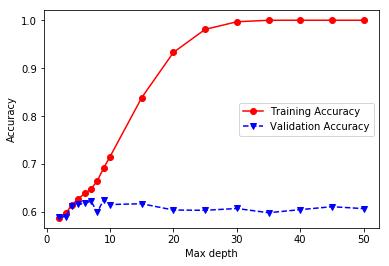

In [8]:
from sklearn import tree
from sklearn.metrics import accuracy_score

#########################################
# Model fitting and evaluation
#########################################

maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]

trainAcc = np.zeros(len(maxdepths))
valAcc = np.zeros(len(maxdepths))

index = 0
for depth in maxdepths:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predVal = clf.predict(X_val)
    trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
    valAcc[index] = accuracy_score(Y_val, Y_predVal)
    index += 1
    
#########################################
# Plot of training and test accuracies
#########################################
    
plt.plot(maxdepths,trainAcc,'ro-',maxdepths,valAcc,'bv--')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

#### Note:
Model starts overfitting after max_depth crosses 5 approximately.  
Thus we set this parameter to 5.

## Training Finalized Decision Tree
With max_depth set to 5 and max_leaf_nodes set to 15 we train our final decision tree model and show the performace below.

In [9]:
#### Train model ####
# clf = tree.DecisionTreeClassifier(max_depth=5, max_leaf_nodes=100, min_samples_split=100)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, Y_train)


### Visualizing Model:
The model is saved as "DPN_tree.pdf" file. Please open it to see the induced tree.

In [10]:
## Visual
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_train.columns,
                                filled=True, rounded=True,
                                special_characters=True,
                                class_names=['negative', 'positive'])

#### Display Results ####
import pydotplus 
from IPython.display import Image

graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

graph = graphviz.Source(dot_data)
graph.render("DPN_tree")
print('For better image: please check the pdf: "DPN_tree.pdf"')


For better image: please check the pdf: "DPN_tree.pdf"


### Model Performance Analysis
Now I calculated the training and validation performance of the model in terms of Sensitivity and Specificity.

In [11]:
## Performance Analysis
Y_predTrain = clf.predict(X_train)
tn, fp, fn, tp = confusion_matrix(Y_train, Y_predTrain, labels=['Negative', 'Positive']).ravel()
print('For Training Dataset')
print('Sensitivity', tp/(tp+fn))
print('Specificity', tn/(tn+fp))

#### Validate model ####
Y_predVal = clf.predict(X_val)
tn, fp, fn, tp = confusion_matrix(Y_val, Y_predVal, labels=['Negative', 'Positive']).ravel()
print('\n\nFor Validation Dataset')
print('Sensitivity', tp/(tp+fn))
print('Specificity', tn/(tn+fp))

# Saving Performance parameters
senArray.append(tp/(tp+fn))
specArray.append(tn/(tn+fp))

For Training Dataset
Sensitivity 0.6682785299806576
Specificity 0.5911764705882353


For Validation Dataset
Sensitivity 0.6437093275488069
Specificity 0.5891350210970464


#### Note:
We were able to avoid overfitting almost perfectly :)

# Ensemble Learners
____
For ensemble learners I tried out with:
1. Random Forest
2. Bagging
3. AdaBoost

### Hyperparameters
* numBaseClassifiers = 500
* maxdepth = 10

### Training

In [12]:
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier

numBaseClassifiers = 500
maxdepth = 5
trainAcc = []
valAcc = []
trainSen = [] # Sensitivity
trainSpec = [] # Specificity
valSen = []
valSpec = []

# Training Random Forest
clf = ensemble.RandomForestClassifier(n_estimators=numBaseClassifiers, n_jobs=-1)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predVal = clf.predict(X_val)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
valAcc.append(accuracy_score(Y_val, Y_predVal))
tn, fp, fn, tp = confusion_matrix(Y_train, Y_predTrain, labels=['Negative', 'Positive']).ravel()
trainSen.append(tp/(tp+fn)); trainSpec.append(tn/(tn+fp));
tn, fp, fn, tp = confusion_matrix(Y_val, Y_predVal, labels=['Negative', 'Positive']).ravel()
valSen.append(tp / (tp + fn)); valSpec.append(tn / (tn + fp));
# Saving Performance parameters
senArray.append(tp/(tp+fn))
specArray.append(tn/(tn+fp))


# Training using Bagging
clf = ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers, n_jobs=-1)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predVal = clf.predict(X_val)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
valAcc.append(accuracy_score(Y_val, Y_predVal))
tn, fp, fn, tp = confusion_matrix(Y_train, Y_predTrain, labels=['Negative', 'Positive']).ravel()
trainSen.append(tp/(tp+fn)); trainSpec.append(tn/(tn+fp));
tn, fp, fn, tp = confusion_matrix(Y_val, Y_predVal, labels=['Negative', 'Positive']).ravel()
valSen.append(tp / (tp + fn)); valSpec.append(tn / (tn + fp));
# Saving Performance parameters
senArray.append(tp/(tp+fn))
specArray.append(tn/(tn+fp))


# Training using AdaBoost
clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predVal = clf.predict(X_val)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
valAcc.append(accuracy_score(Y_val, Y_predVal))
tn, fp, fn, tp = confusion_matrix(Y_train, Y_predTrain, labels=['Negative', 'Positive']).ravel()
trainSen.append(tp/(tp+fn)); trainSpec.append(tn/(tn+fp));
tn, fp, fn, tp = confusion_matrix(Y_val, Y_predVal, labels=['Negative', 'Positive']).ravel()
valSen.append(tp / (tp + fn)); valSpec.append(tn / (tn + fp));
# Saving Performance parameters
senArray.append(tp/(tp+fn))
specArray.append(tn/(tn+fp))

### Visualizing Performance




Training Data
trainSen [1.0, 0.6865328820116054, 1.0]
trainSpec [1.0, 0.6095860566448802, 1.0]


Val Data
valSen [0.6133405639913232, 0.6702819956616052, 0.5802603036876356]
valSpec [0.7262658227848101, 0.5954641350210971, 0.6329113924050633]
Done


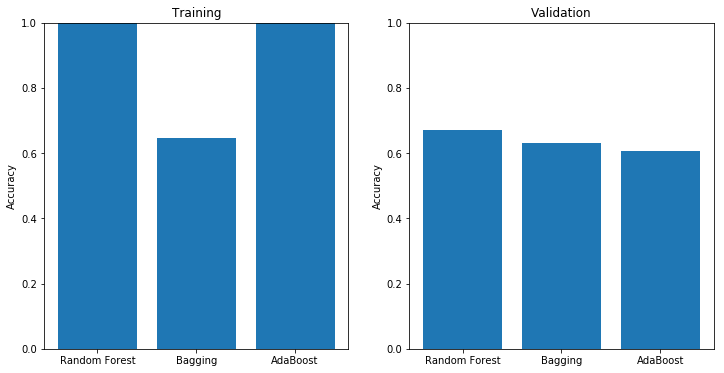

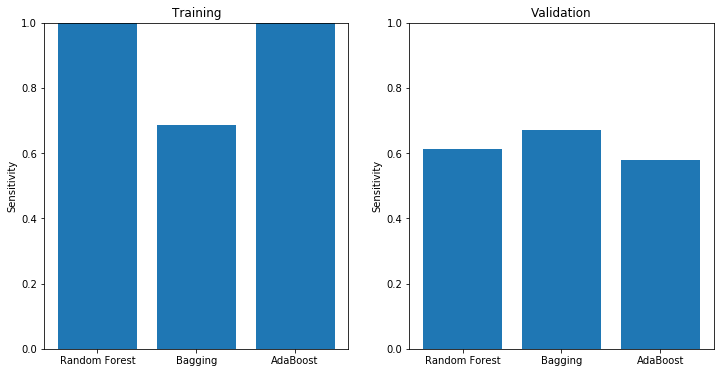

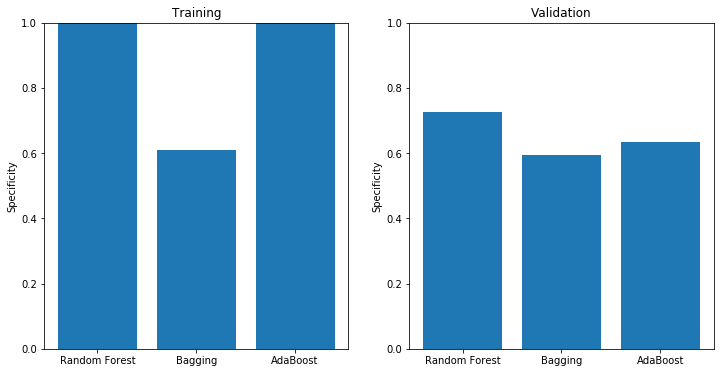

In [13]:
methods = ['Random Forest', 'Bagging', 'AdaBoost']

# Accuracy Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.bar([1.5,2.5,3.5], trainAcc)
ax1.set_xticks([1.5,2.5,3.5])
ax1.set_xticklabels(methods)
ax2.bar([1.5,2.5,3.5], valAcc)
ax2.set_xticks([1.5,2.5,3.5])
ax2.set_xticklabels(methods)
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Accuracy')
ax1.set_title('Training')
ax2.set_title('Validation')
ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])

# Sensitivity Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.bar([1.5,2.5,3.5], trainSen)
ax1.set_xticks([1.5,2.5,3.5])
ax1.set_xticklabels(methods)
ax2.bar([1.5,2.5,3.5], valSen)
ax2.set_xticks([1.5,2.5,3.5])
ax2.set_xticklabels(methods)
ax1.set_ylabel('Sensitivity')
ax2.set_ylabel('Sensitivity')
ax1.set_title('Training')
ax2.set_title('Validation')
ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])

# Specificity Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.bar([1.5,2.5,3.5], trainSpec)
ax1.set_xticks([1.5,2.5,3.5])
ax1.set_xticklabels(methods)
ax2.bar([1.5,2.5,3.5], valSpec)
ax2.set_xticks([1.5,2.5,3.5])
ax2.set_xticklabels(methods)
ax1.set_ylabel('Specificity')
ax2.set_ylabel('Specificity')
ax1.set_title('Training')
ax2.set_title('Validation')
ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])

print('\n\n')
print('Training Data')
print('trainSen', trainSen)
print('trainSpec', trainSpec)
print('\n')
print('Val Data')
print('valSen', valSen)
print('valSpec', valSpec)
print('Done')

# SVM Classifier
___
## Hyperparameters Setting
For SVM I used the a Gaussian radial basis function kernel. I varied the Penalty parameter C of the error term, from 0.02 to 10 to see the effect and choose the best C for my problem.

Text(0, 0.5, 'Accuracy')

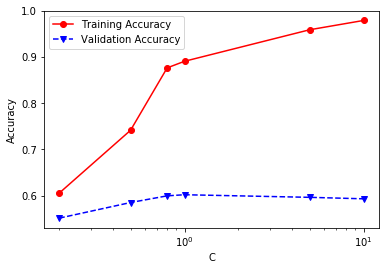

In [14]:
from sklearn.svm import SVC

C = [0.2, 0.5, 0.8, 1, 5, 10]
SVMtrainAcc = []
SVMvalAcc = []

for param in C:
    clf = SVC(C=param,kernel='rbf',gamma='auto')
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predVal = clf.predict(X_val)
    SVMtrainAcc.append(accuracy_score(Y_train, Y_predTrain))
    SVMvalAcc.append(accuracy_score(Y_val, Y_predVal))

plt.plot(C, SVMtrainAcc, 'ro-', C, SVMvalAcc,'bv--')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Accuracy')

#### Note:
For C=1 we get the higheset accuracy. So, for SVM I select this value for my final SVM model.

## Training Finalized SVM and Performance Analysis
Now setting C= and kernel="rbf" I train my final mode and present performnce values.

In [15]:
clf = SVC(C=1,kernel='rbf',gamma='auto')
clf.fit(X_train, Y_train)

Y_predTrain = clf.predict(X_train)
Y_predVal = clf.predict(X_val)

## Performance Analysis
Y_predTrain = clf.predict(X_train)
tn, fp, fn, tp = confusion_matrix(Y_train, Y_predTrain, labels=['Negative', 'Positive']).ravel()
print('For Training Dataset')
print('Sensitivity', tp/(tp+fn))
print('Specificity', tn/(tn+fp))

#### Validate model ####
Y_predVal = clf.predict(X_val)
tn, fp, fn, tp = confusion_matrix(Y_val, Y_predVal, labels=['Negative', 'Positive']).ravel()
print('\n\nFor Validation Dataset')
print('Sensitivity', tp/(tp+fn))
print('Specificity', tn/(tn+fp))

# Saving Performance parameters
senArray.append(tp/(tp+fn))
specArray.append(tn/(tn+fp))

For Training Dataset
Sensitivity 0.8852756286266924
Specificity 0.8947712418300654


For Validation Dataset
Sensitivity 0.46203904555314534
Specificity 0.7378691983122363


# Performance Summary:
In this notebook, I tried out with Decision Tree, Random Forest, Bagging, Boosing and SVM classifers. Following is  the summary of their performance. It can be observed that, the Bagging method prodeces the highes Sensitivity of 67% while the SVM method produces the highest specificity of 73%.

In [54]:
methods = ['Decision Tree', 'Random Forest', 'Bagging', 'Boosting', 'SVM']
from tabulate import tabulate
print(tabulate([['Sensitivity']+senArray, ['Specificity']+specArray], headers=['Metric']+methods))

Metric         Decision Tree    Random Forest    Bagging    Boosting       SVM
-----------  ---------------  ---------------  ---------  ----------  --------
Sensitivity         0.643709         0.613341   0.670282    0.58026   0.462039
Specificity         0.589135         0.726266   0.595464    0.632911  0.737869
